In [ ]:
!pip install pydub

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [ ]:
import librosa
import librosa.display
from pydub import AudioSegment

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image

In [ ]:
def count_audio_files(directory="speech"):
    mp3_files = [f for f in os.listdir(directory) if f.endswith(".mp3")]
    return len(mp3_files)

num_files = count_audio_files("speech")
print(f"There are {num_files} audio files in the 'speech' directory.")

There are 500 audio files in the 'speech' directory.


In [ ]:
mp3_folder = "speech"
wav_dir = "speech_wav"

if not os.path.exists(wav_dir):
    os.makedirs(wav_dir)

In [ ]:
mp3_files = glob.glob(os.path.join(mp3_folder, "*.mp3"))

if len(mp3_files) == 0:
    print(f"No .mp3 files found in the '{mp3_folder}' folder.")

In [ ]:
for mp3_file in mp3_files:
    file_name = os.path.basename(mp3_file).replace(".mp3", ".wav")
    wav_file = os.path.join(wav_dir, file_name)

    audio = AudioSegment.from_mp3(mp3_file)
    audio.export(wav_file, format="wav")

In [ ]:
print(f"Converted {len(mp3_files)} .mp3 files from '{mp3_folder}' to '{wav_dir}'.")

Converted 500 .mp3 files from 'speech' to 'speech_wav'.


In [ ]:
wav_dir = "speech_wav"
spectrogram_dir = "spectrograms"

if not os.path.exists(spectrogram_dir):
    os.makedirs(spectrogram_dir)

In [ ]:
wav_files = glob.glob(os.path.join(wav_dir, "*.wav"))

if len(wav_files) == 0:
    print(f"No .wav files found in '{wav_dir}' folder.")

In [ ]:
for wav_file in wav_files:
    y, sr = librosa.load(wav_file, sr=None)

    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_db = librosa.power_to_db(S, ref=np.max)

    file_name = os.path.basename(wav_file).replace(".wav", ".png")

    plt.figure(figsize=(10, 6))
    librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Spectrogram of {file_name}")

    plt.savefig(os.path.join(spectrogram_dir, file_name))
    plt.close()

In [ ]:
spectrogram_files = glob.glob("spectrograms/*.png")
print(f"Number of spectrogram files: {len(spectrogram_files)}")

if len(spectrogram_files) > 0:
    print("Spectrogram files loaded.")
else:
    print("No spectrogram files found in the directory.")

Number of spectrogram files: 500
Spectrogram files loaded.


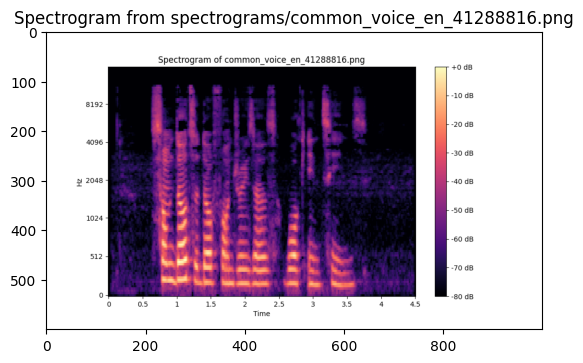

In [ ]:
if len(spectrogram_files) > 0:
    img = mpimg.imread(spectrogram_files[0])
    plt.imshow(img)
    plt.title(f"Spectrogram from {spectrogram_files[0]}")
    plt.show()
else:
    print("No spectrograms to display.")

In [ ]:
spectrograms = [np.random.rand(128, 128) for _ in range(500)]

if len(spectrograms) == 0:
    print("No spectrograms to process.")
else:
    print(f"Processing {len(spectrograms)} spectrograms.")

Processing 500 spectrograms.


In [ ]:
flattened_spectrograms = [s.flatten() for s in spectrograms]
print(f"Spectrograms flattened: {len(flattened_spectrograms)} entries.")

scaler = StandardScaler()
flattened_spectrograms = scaler.fit_transform(flattened_spectrograms)

Spectrograms flattened: 500 entries.


In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(flattened_spectrograms)

print(f"DBSCAN labels: {labels[:10]}...")

anomalies = np.sum(labels == -1)
print(f"Anomalies detected: {anomalies}")

DBSCAN labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]...
Anomalies detected: 500


In [ ]:
spectrograms = [np.random.rand(128, 128) for _ in range(50)]
labels = np.random.choice([-1, 1], size=50)

X = np.array(spectrograms)[..., np.newaxis]
print(f"Shape of X (features): {X.shape}")

X = (X - np.mean(X)) / np.std(X)

y = (labels == -1).astype(int)
print(f"Shape of y (labels): {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape: X_test={X_test.shape}, y_test={y_test.shape}")

Shape of X (features): (50, 128, 128, 1)
Shape of y (labels): (50,)
Training data shape: X_train=(40, 128, 128, 1), y_train=(40,)
Testing data shape: X_test=(10, 128, 128, 1), y_test=(10,)


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Model Summary:")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,515,713 (24.86 MB)

 Trainable params: 6,515,713 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("Training model...")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

print("Training loss and accuracy:")
for epoch, (loss, acc) in enumerate(zip(history.history['loss'], history.history['accuracy'])):
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")

Training model...
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6250 - loss: 1.0960 - val_accuracy: 0.6000 - val_loss: 0.6838
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 931ms/step - accuracy: 0.6146 - loss: 0.7280 - val_accuracy: 0.4000 - val_loss: 0.7015
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step - accuracy: 0.5333 - loss: 0.7357 - val_accuracy: 0.4000 - val_loss: 1.1108
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 366ms/step - accuracy: 0.5813 - loss: 0.7638 - val_accuracy: 0.4000 - val_loss: 0.7158
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - accuracy: 0.6687 - loss: 0.6366 - val_accuracy: 0.6000 - val_loss: 0.6774
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6958 - loss: 0.6480 - val_accuracy: 0.4000 - val_loss: 0.7002
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - accuracy: 0.7333 - loss: 0.6312 - val_accuracy: 0.4000 - val_loss: 0.7135
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 554ms/step - accuracy: 0.7604 - loss: 0.6083 - val_accuracy: 0.

In [ ]:
print("Evaluating model...")
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy on test data: {accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Model Accuracy on test data: 70.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       1.00      0.25      0.40         4

    accuracy                           0.70        10
   macro avg       0.83      0.62      0.60        10
weighted avg       0.80      0.70      0.64        10



Mismatch: labels=50, reduced_data=500


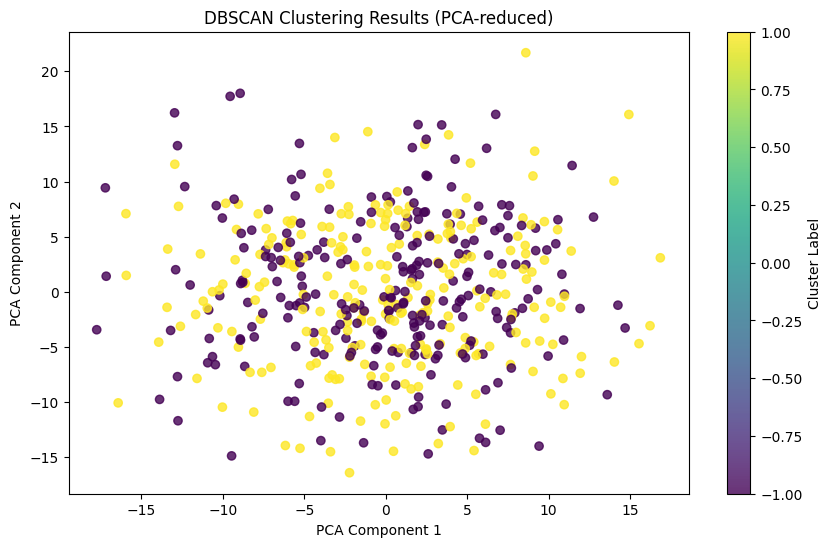

In [ ]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(flattened_spectrograms)

if len(labels) != len(reduced_data):
    print(f"Mismatch: labels={len(labels)}, reduced_data={len(reduced_data)}")
    labels = np.resize(labels, len(reduced_data))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', alpha=0.8)
plt.colorbar(scatter, label="Cluster Label")
plt.title("DBSCAN Clustering Results (PCA-reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

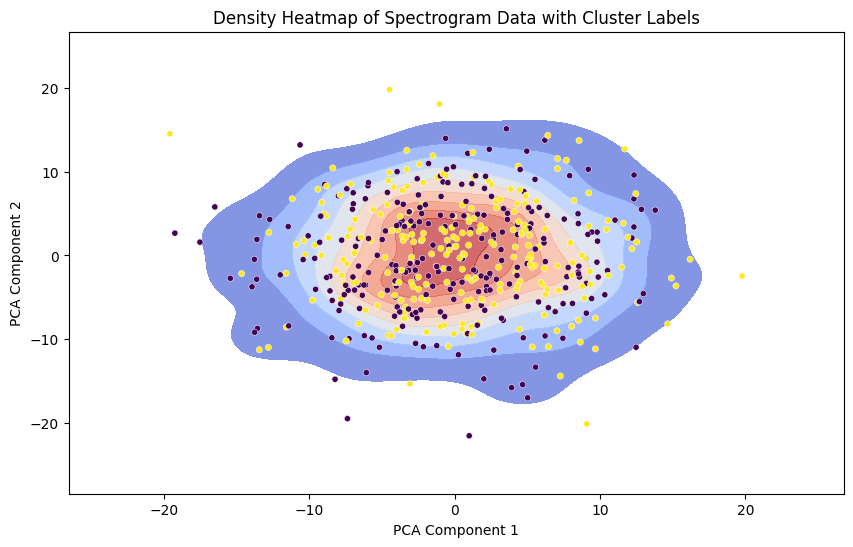

In [ ]:
reduced_data = pca.fit_transform(flattened_spectrograms)

plt.figure(figsize=(10, 6))
sns.kdeplot(x=reduced_data[:, 0], y=reduced_data[:, 1], fill=True, cmap="coolwarm", alpha=0.7)
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette="viridis", s=20, legend=None)
plt.title("Density Heatmap of Spectrogram Data with Cluster Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()